In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from func_file_Model import *
from func_file_Localization import *

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### Load model and sample data

In [3]:
model = Load_CNN_model("Model/CNN_model.h5")
sample = np.load("Data/Sample_1.npy")

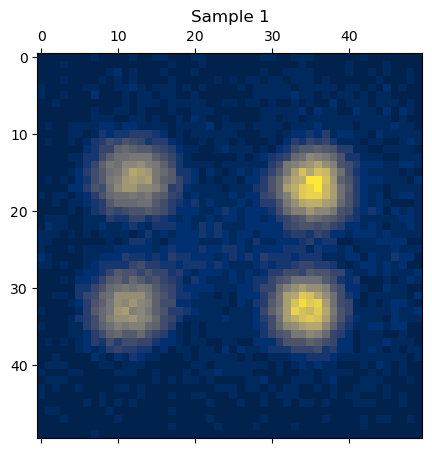

In [4]:
plt.figure(figsize=(5,5))
plt.matshow(sample, cmap="cividis", fignum=False)
plt.title("Sample 1")

plt.show()

### Dot localization

In [5]:
#Restriction for np.max search, fit is done within this restriction
restr_1 = (0, 25, 0, 25)
restr_2 = (0, 25, 25, 50)
restr_3 = (25, 50, 0, 25)
restr_4 = (25, 50, 25, 50)

restr_list = [restr_1, restr_2, restr_3, restr_4]

In [6]:
#Localize the dots in the image
positions_loc, stds_loc, sigmas_loc = Find_given_centers(sample, restr_list, fit_size=6)

#Rescale the positions from 50x50 measured grid to 200x200 CNN-recondstructed grid
positions_loc_adjusted = positions_loc * 200/50 + 1.5
stds_loc_adjusted = stds_loc * 200/50

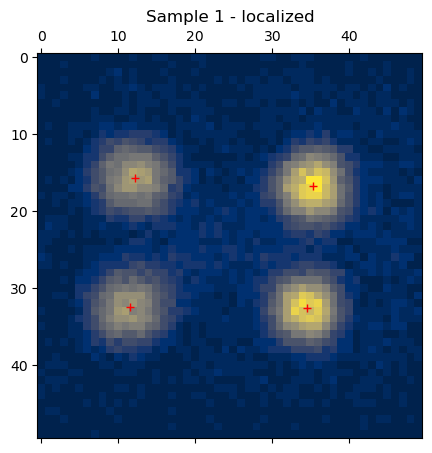

In [7]:
plt.figure(figsize=(5,5))
plt.matshow(sample, cmap="cividis", fignum=False)
plt.plot(positions_loc[:,1], positions_loc[:,0], '+', color="red")
plt.title("Sample 1 - localized")

plt.show()

In [8]:
for i in range(positions_loc.shape[0]):
    print("Dot '" + str(i+1) + "' position in 50x50: (" + 
          str(np.round(positions_loc[i,0],3)) + "+-" + str(np.round(stds_loc[i,0],3)) + ", " +
          str(np.round(positions_loc[i,1],3)) + "+-" + str(np.round(stds_loc[i,1],3)) + ")")

print("")

for i in range(positions_loc_adjusted.shape[0]):
    print("Dot '" + str(i+1) + "' position in 200x200: (" + 
          str(np.round(positions_loc_adjusted[i,0],3)) + "+-" + str(np.round(stds_loc_adjusted[i,0],3)) + ", " +
          str(np.round(positions_loc_adjusted[i,1],3)) + "+-" + str(np.round(stds_loc_adjusted[i,1],3)) + ")")

Dot '1' position in 50x50: (15.703+-0.041, 12.23+-0.045)
Dot '2' position in 50x50: (16.812+-0.035, 35.292+-0.033)
Dot '3' position in 50x50: (32.468+-0.046, 11.551+-0.049)
Dot '4' position in 50x50: (32.627+-0.034, 34.477+-0.034)

Dot '1' position in 200x200: (64.31+-0.164, 50.421+-0.18)
Dot '2' position in 200x200: (68.749+-0.138, 142.667+-0.132)
Dot '3' position in 200x200: (131.372+-0.184, 47.705+-0.197)
Dot '4' position in 200x200: (132.008+-0.137, 139.409+-0.134)


### CNN reconstruction

In [9]:
reconstructed = CNN_predict(model, sample)

1/1 [==============================] - 2s 2s/step


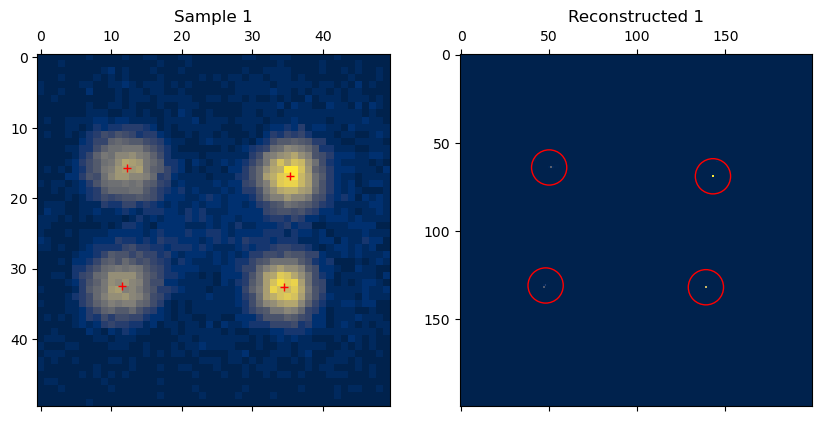

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(sample, cmap="cividis", fignum=False)
plt.plot(positions_loc[:,1], positions_loc[:,0], '+', color="red")
plt.title("Sample 1")

plt.subplot(122)
plt.matshow(reconstructed, cmap="cividis", fignum=False, vmin=reconstructed.min(), vmax=reconstructed.max())
for i in range(positions_loc_adjusted.shape[0]):
    x,y = positions_loc_adjusted[i].round(0)
    plt.gca().add_patch(mpl.patches.Circle([y,x], 10, linewidth=1, edgecolor='red', facecolor='none'))
plt.title("Reconstructed 1")

plt.show()

### Vizualize

In [11]:
#Get positions of maximum values in CNN-reconstructed image 
positions_of_max = [
    np.unravel_index(np.argmax(reconstructed[0:100,0:100]), [100,100]) + np.array([0,0]), 
    np.unravel_index(np.argmax(reconstructed[0:100,100:200]), [100,100]) + np.array([0,100]), 
    np.unravel_index(np.argmax(reconstructed[100:200,0:100]), [100,100]) + np.array([100,0]), 
    np.unravel_index(np.argmax(reconstructed[100:200,100:200]), [100,100]) + np.array([100,100])
]
positions_of_max

[array([64, 51]), array([ 69, 143]), array([132,  47]), array([132, 139])]

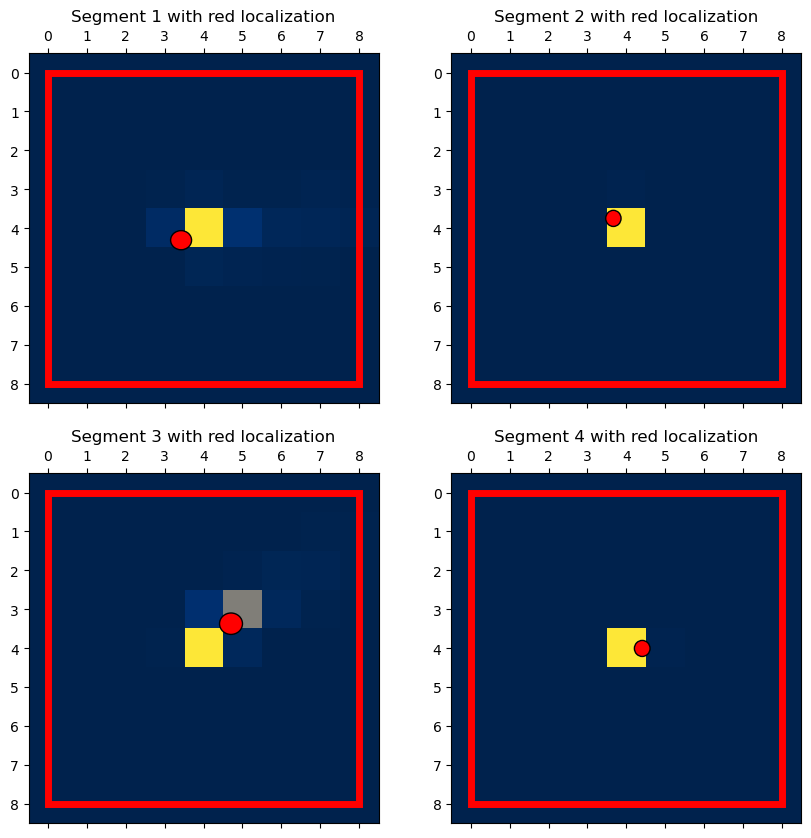

In [12]:
halfsize = 4
std_multi = 3 #uncertainity, multiples of sigma for red circles

REC_center_of_mass_array = np.zeros([4,2])
LOC_center_of_mass_array = np.zeros([4,2])

plt.figure(figsize=(10,10))
for i in range(len(positions_of_max)):
    plt.subplot(2,2,i+1)
    x,y = positions_of_max[i]
    
    plt.matshow(reconstructed[x-halfsize:x+halfsize+1, y-halfsize:y+halfsize+1], cmap="cividis", fignum=False)
    
    com_x, com_y = scipy.ndimage.center_of_mass(reconstructed[x-halfsize:x+halfsize+1, y-halfsize:y+halfsize+1])
    REC_center_of_mass_array[i] = (com_x, com_y)
    
    plt.gca().add_patch(mpl.patches.Rectangle([0,0], 2*halfsize, 2*halfsize, linewidth=5, edgecolor='red', facecolor='none'))
    plt.gca().add_patch(mpl.patches.Ellipse([positions_loc_adjusted[i,1] - (y - halfsize), positions_loc_adjusted[i,0] - (x - halfsize)], 
                                            stds_loc_adjusted[i,1] * std_multi, stds_loc_adjusted[i,0] * std_multi, 
                                            alpha=1, edgecolor='black', facecolor='red'))
    LOC_center_of_mass_array[i] = [positions_loc_adjusted[i,0] - (x - halfsize), positions_loc_adjusted[i,1] - (y - halfsize)]
    
    plt.title("Segment " + str(i+1) + " with red localization")

plt.show()

### Estimate resolution variables

In [13]:
#Turn the sigma_x and sigma_y into single sigma_xy for each dot
sigmas_xy = np.sqrt(np.mean(sigmas_loc**2, axis=1))    #sqrt( (x**2 + y**2) / 2 )

#Average the four sigmas
sigmas_average = np.mean(sigmas_xy)

#Get Rayleigh resolution limit; defined as first dark ring in the Airy disc
rayleigh_resolution_limit_in_50px = Gaussian_sigma_to_Airy_min(sigmas_average)
print("Estimated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_50px,4), "px of the 50x50 grid.")

#Rescale to um
px_to_camera_um_in_50px = 5*1.85
rayleigh_resolution_limit_in_camera_um = rayleigh_resolution_limit_in_50px * px_to_camera_um_in_50px
print("Estimated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_camera_um,4), "um in the camera plane.")

Estimated Rayleigh limit is app. 9.2948 px of the 50x50 grid.
Estimated Rayleigh limit is app. 85.9772 um in the camera plane.


In [14]:
#Calculate the Rayleigh limit using imaging setup parameters
wavelength = 910 #nm
NA = 0.7

rayleigh_resolution_limit_in_sample_um = (0.61 * wavelength / NA) / 1000
print("Calculated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_sample_um,4), "um in the sample plane.")

Calculated Rayleigh limit is app. 0.793 um in the sample plane.


In [15]:
#Estimate the magnification of the imaging setup
magnification = rayleigh_resolution_limit_in_camera_um / rayleigh_resolution_limit_in_sample_um
print("Estimated magnification of the imaging setup is app.", np.round(magnification, 2))

Estimated magnification of the imaging setup is app. 108.42


In [16]:
#Calculate the distance between the reconstruction center of mass and localization position - extremely low number
distances_in_200px = np.linalg.norm(REC_center_of_mass_array - LOC_center_of_mass_array, axis=1)
average_distance_in_200px = np.mean(distances_in_200px)

#Rescale to nm
average_distance_in_50px = average_distance_in_200px / 4
average_distance_in_camera_um = average_distance_in_50px * px_to_camera_um_in_50px
average_distance_in_sample_um = average_distance_in_camera_um / magnification
average_distance_in_sample_nm = average_distance_in_sample_um * 1000

print("Average distance is app.", np.round(average_distance_in_sample_nm,2), "nm.")
print("Which is app.", np.round(rayleigh_resolution_limit_in_sample_um/average_distance_in_sample_um,4), "times below the Rayleigh limit.")

Average distance is app. 10.83 nm.
Which is app. 73.2487 times below the Rayleigh limit.
